Time Reweighting
====

I want to reweight a distribution of times to a known distribution:


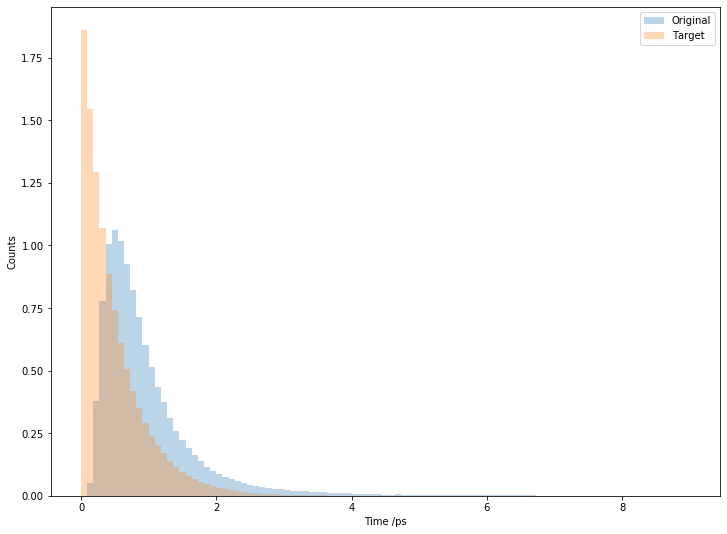

In [7]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Read the decay times from the LHCb simulation - I've serialised it here
with open("mc_times.pickle", "rb") as f:
    mc_times = pickle.load(f)

# Generate some random numbers from an exponential distribution with the right decay constant
d_lifetime_ps = 0.49
N = len(mc_times)
exp_times = np.random.exponential(d_lifetime_ps, N)

def plots(target, original, target_wt=None, original_wt=None):
    kw = {"bins": np.linspace(0.0, 9.0, 100), "alpha": 0.3, "density": True}
    plt.figure(figsize=(12.0, 9.0))
    
    plt.hist(original, label="Original", weights=original_wt, **kw)
    plt.hist(target, label="Target", weights=target_wt, **kw)
    plt.legend()

    plt.xlabel("Time /ps")
    plt.ylabel("Counts")
    plt.show()
    
plots(exp_times, mc_times)

To do this let's use the gradient-boosted decision tree algorithm from the [hep-ml](https://arogozhnikov.github.io/hep_ml/_modules/hep_ml/reweight.html#GBReweighter) package:

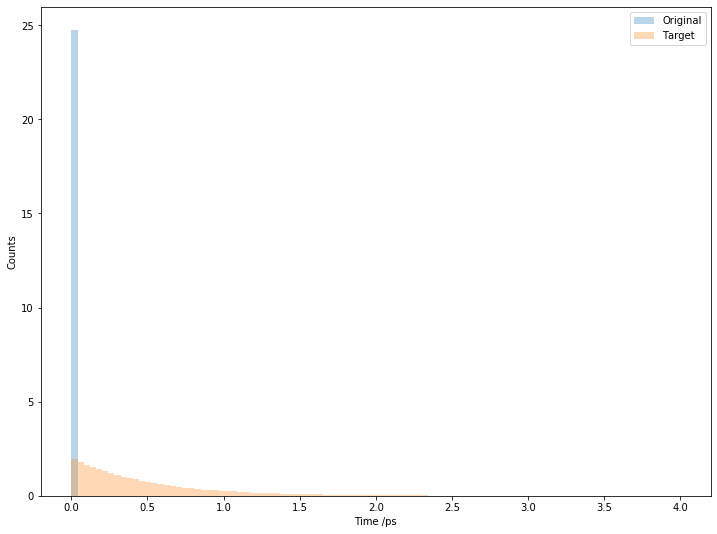

In [4]:
from hep_ml.reweight import GBReweighter
from sklearn.model_selection import train_test_split

mc_train, mc_test, model_train, model_test = train_test_split(mc_times, exp_times)

bdt = GBReweighter()
bdt.fit(original=mc_train, target=model_train)
weights = bdt.predict_weights(mc_test)

plots(model_test, mc_test, original_wt=weights)

That didn't work - maybe it is because we are trying to reweight from zero counts (at around t~0 for the original distribution) to non-zero counts; perhaps if we try to reweight in the other direction it will work:

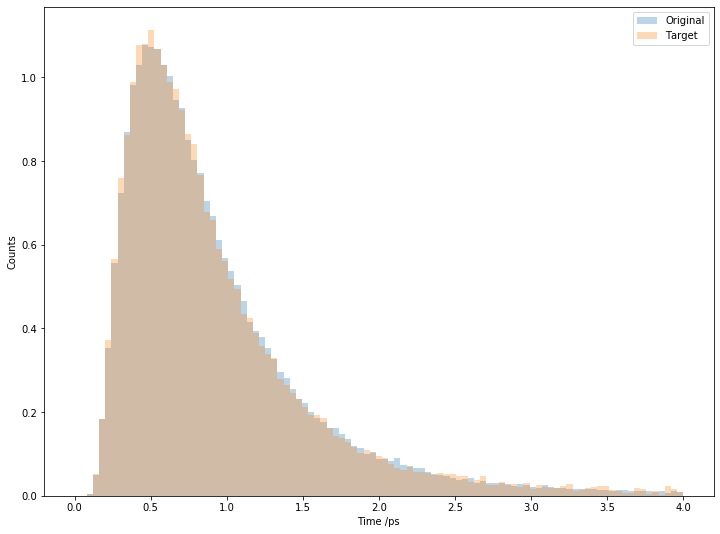

In [5]:
bdt = GBReweighter()

# This time, train the BDT to reweight our exponential to the MC decay times.
bdt.fit(original=model_train, target=mc_train)
weights = bdt.predict_weights(model_test)

# Plot the same way round as before to keep the plot colours consistent, though
plots(model_test, mc_test, target_wt=weights)

ok im not sure why that worked, it didn't work when I tried weighting exponential -> MC using weights to define my exponential:


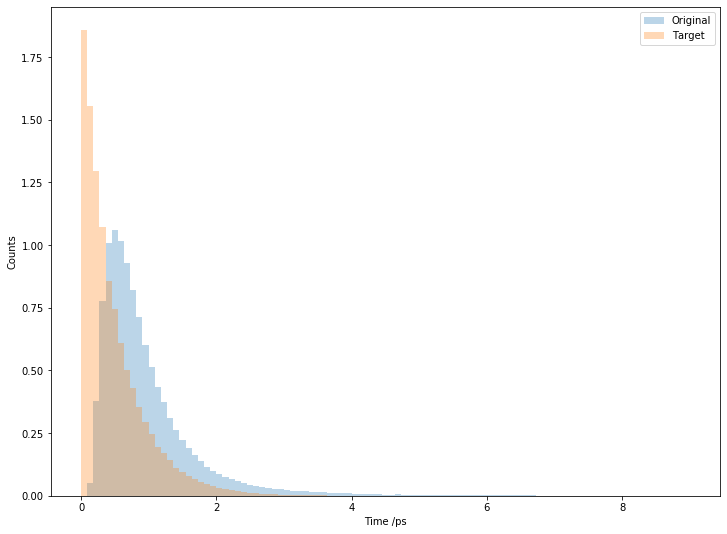

In [16]:
flat = np.random.uniform(0.0, np.max(mc_times), N)
flat_wt = np.exp(-flat/d_lifetime_ps)

plots(flat, mc_times, target_wt=flat_wt)

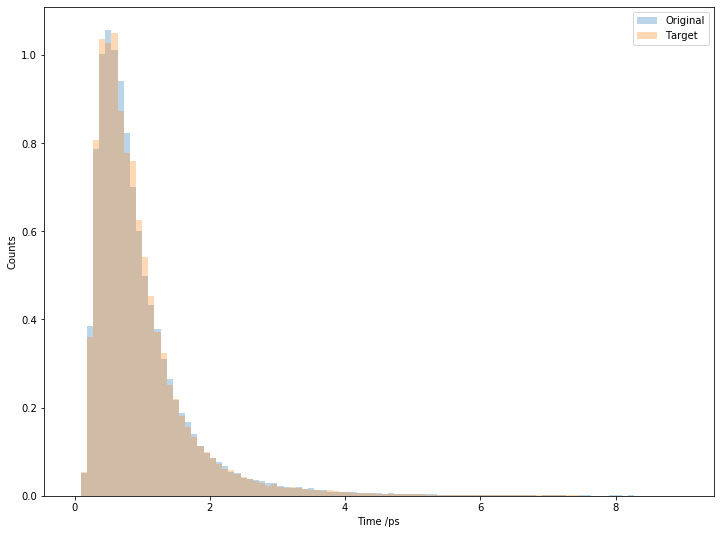

In [17]:
mc_train, mc_test, model_train, model_test, flat_wt_train, flat_wt_test = train_test_split(mc_times, flat, flat_wt)

bdt = GBReweighter()

bdt.fit(original=model_train, target=mc_train, original_weight=flat_wt_train)
weights = bdt.predict_weights(model_test)

plots(model_test, mc_test, target_wt=weights*flat_wt_test)

oh, it does work. what